# Generate state vector netcdf file from shape file

Use this notebook to create an IMI state vector file for an irregular region of interest using a shape file for the region.

- Step 1: Upload the shape file to EC2
- Step 2: Copy the path to the shape file into the configuration file (config.yml)
- Step 3: Open this notebook (instructions: https://docs.aws.amazon.com/dlami/latest/devguide/setup-jupyter.html)
- Step 4: Run the notebook
- Step 5: When satisfied with the state vector, set save switch in final cell to True and save the netcdf

Example here is for the Permian Basin.

In [1]:
import sys
import xarray as xr 
import numpy as np
import fiona
import regionmask
import xesmf as xe
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from sklearn.cluster import KMeans
import colorcet as cc
import matplotlib
import matplotlib.pyplot as plt
import yaml
import warnings; warnings.filterwarnings(action='ignore')
sys.path.append('../../')
from src.utilities.make_state_vector_file import cluster_buffer_elements
from src.utilities.utils import download_landcover_files, download_hemcodiags_files
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /home/tskipper/.conda/envs/imi_env/share/proj failed


## Setup

In [2]:
# Read config file
config = yaml.load(open("/work/MOD3DEV/tskipper/methane/imi/integrated_methane_inversion/config.yml"), Loader=yaml.FullLoader)

In [3]:
# Download landcover files from s3 if not already present
# download_landcover_files(config)
# download_hemcodiags_files(config)

In [4]:
# Open shape file with geopandas
shape = gpd.read_file(config['ShapeFile'])
shape

,geometry
0,"POLYGON ((-100.54152 33.84438, -100.50482 33.6..."


In [5]:
# Define min/max latitude and longitude for inversion domain
buffer_deg = config['BufferDeg']
if config["Res"] == "4.0x5.0":
    deg_lat, deg_lon = 4.0, 5.0 
elif config["Res"] == "2.0x2.5":
    deg_lat, deg_lon = 2.0, 2.5
elif config["Res"] == "0.5x0.625":
    deg_lat, deg_lon = 0.5, 0.625
elif config["Res"] == "0.25x0.3125":
    deg_lat, deg_lon = 0.25, 0.3125
bufferdeg_min_lat = deg_lat * 3
bufferdeg_min_lon = deg_lon * 3

# set the buffer degrees to the maximum to ensure 
# that the buffer is at least the minimum (3 extra grid cells on each side)
buffer_deg_lat = max(buffer_deg, bufferdeg_min_lat)
buffer_deg_lon = max(buffer_deg, bufferdeg_min_lon)

bounds = shape.bounds
lon_min = bounds['minx'][0] - buffer_deg_lon
lon_max = bounds['maxx'][0] + buffer_deg_lon
lat_min = bounds['miny'][0] - buffer_deg_lat
lat_max = bounds['maxy'][0] + buffer_deg_lat

# Create lat/lon grid (can increase dlon, dlat if the regridding in next steps is slow)
dlon = 0.01
dlat = 0.01
lon = np.arange(lon_min, lon_max+dlon, dlon)
lat = np.arange(lat_min, lat_max+dlat, dlat)

# Inversion spatial resolution
if config['Res'] == '0.25x0.3125':
    lat_res = 0.25
    lon_res = 0.3125
elif config['Res'] == '0.5x0.625':
    lat_res = 0.5
    lon_res = 0.625

## Create region of interest mask from shape file

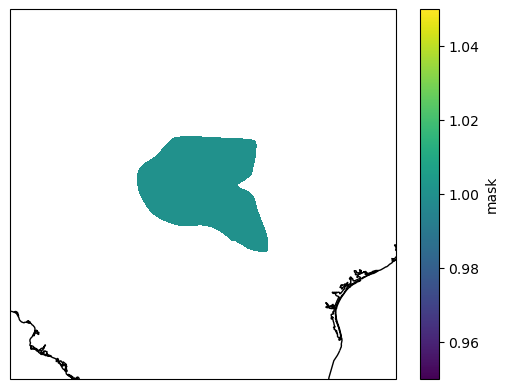

In [6]:
# Make mask from shape file
mask = regionmask.mask_geopandas(shape, lon, lat) + 1 # Add 1 so the mask values are 1 instead of 0

# View the mask in the inversion domain
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
)
ax.coastlines();

## Regrid mask to 0.25 x 0.3125 or 0.5x0.625 grid

In [7]:
# Need to regrid to the grid HEMCO expects
reference_lat_grid = np.arange(-90 , 90+lat_res , lat_res)
reference_lon_grid = np.arange(-180, 180+lon_res, lon_res)

# Find closest reference coordinates to selected lat/lon bounds
lat_min = reference_lat_grid[np.abs(reference_lat_grid - lat_min).argmin()]
lon_min = reference_lon_grid[np.abs(reference_lon_grid - lon_min).argmin()]
lat_max = reference_lat_grid[np.abs(reference_lat_grid - lat_max).argmin()]
lon_max = reference_lon_grid[np.abs(reference_lon_grid - lon_max).argmin()]

# Create an xESMF regridder object to resample the mask on the grid HEMCO expects
new_lat_grid = np.arange(lat_min, lat_max+lat_res, lat_res)
new_lon_grid = np.arange(lon_min, lon_max+lon_res, lon_res)
ds_out = xr.Dataset({'lat': (['lat'], new_lat_grid),
                     'lon': (['lon'], new_lon_grid),
                    }
                   )
#ds_out = ds_out.rename({'longitude': 'lon', 'latitude': 'lat'})

regridder = xe.Regridder(mask, ds_out, 'nearest_s2d')
regridder

xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_1457x1520_59x50.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1457, 1520) 
Output grid shape:          (59, 50) 
Periodic in longitude?      False

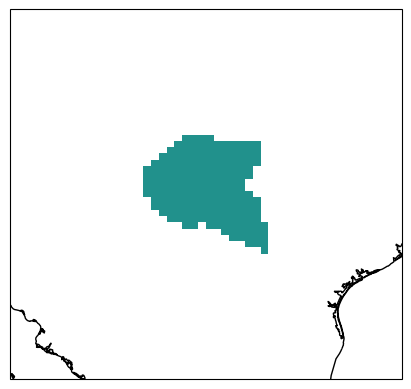

In [8]:
# Regrid the mask
mask = regridder(mask)

# View the regridded mask in the inversion domain
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ax.coastlines();

## Deal with buffer areas and pixels over water

In [9]:
state_vector = mask.copy()

# Set pixels in buffer areas to 0
state_vector.values[mask.isnull()] = 0
state_vector.values[mask.isnull()] = 0

In [10]:
# Get path to land cover file
if config['Met'] == 'GEOSFP':
    met_token1 = 'GEOSFP'
    met_token2 = 'GEOS_FP'
    constYr = 2011
    gridRes = '025x03125'
elif config['Met'] == 'MERRA2':
    met_token1 = 'MERRA2'
    met_token2 = 'MERRA2'
    constYr = 2015
    gridRes = '05x0625'

gridDir = f'{config["Res"]}_{config["RegionID"]}'
land_cover_file = f'{met_token1}.{constYr}0101.CN.{gridRes}.{config["RegionID"]}.nc'
land_cover_pth = f'{config["DataPath"]}/GEOS_{gridDir}/{met_token2}/{constYr}/01/{land_cover_file}'
# hemco_diag_file = f'HEMCO_sa_diagnostics.{gridRes}.2023.nc'
# hemco_diag_pth = f'{config["DataPath"]}/HEMCO/CH4/v2024-07/HEMCO_SA_Output/{hemco_diag_file}'
hemco_diag_file = f'HEMCO_diagnostics.201801010000.nc'
hemco_diag_dir = '/work/MOD3DEV/tskipper/geos-chem/ch4_geosfp_0.25x0.3125/rundir/OutputDir'
hemco_diag_pth = f'{hemco_diag_dir}/{hemco_diag_file}'

In [11]:
# Load land cover data
lc = xr.load_dataset(land_cover_pth)
hd = xr.load_dataset(hemco_diag_pth)

# Group together
lc = (lc['FRLAKE'] + lc['FRLAND'] + lc['FRLANDIC']).drop_vars('time').squeeze()
hd = (hd["EmisCH4_Oil"] + hd["EmisCH4_Gas"]).drop_vars("time").squeeze()

# Subset the area of interest
lc = lc.isel(lon=lc.lon>=lon_min, lat=lc.lat>=lat_min)
lc = lc.isel(lon=lc.lon<=lon_max, lat=lc.lat<=lat_max)
hd = hd.isel(lon=hd.lon >= lon_min, lat=hd.lat >= lat_min)
hd = hd.isel(lon=hd.lon <= lon_max, lat=hd.lat <= lat_max)

# Set pixels over water to 0, unless there are offshore emissions
if config['LandThreshold']:
    # Where there is neither land nor emissions, replace with 0
    land = lc.where((lc > config['LandThreshold']) | (hd > config['OffshoreEmisThreshold']))
    state_vector.values[land.isnull().values] = 0

## Label the state vector elements

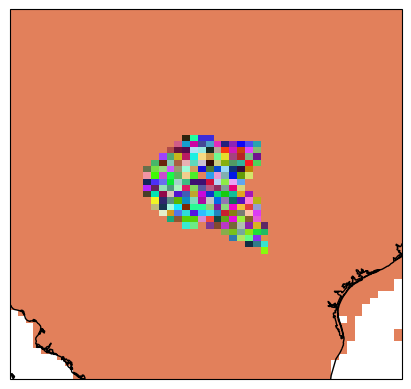

In [12]:
# Enumerate state vector elements
n_lat = len(new_lat_grid)
n_lon = len(new_lon_grid)
count = 1
for r in range(n_lat):
    for c in range(n_lon):
        if state_vector[r,c] == 1:
            state_vector[r,c] = count
            count += 1

# Now set pixels over water to NaN, unless there are offshore emissions
if config['LandThreshold']:
    # Where there is no land or offshore emissions, replace with NaN
    state_vector = state_vector.where((lc > config['LandThreshold']) | (hd > config['OffshoreEmisThreshold']))
            
# Plot
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
num_colors = state_vector.where(mask).max().item()
sv_cmap = matplotlib.colors.ListedColormap(np.random.rand(int(num_colors), 3))
state_vector.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=sv_cmap,
    add_colorbar=False,
)
ax.coastlines();

## Label the buffer clusters

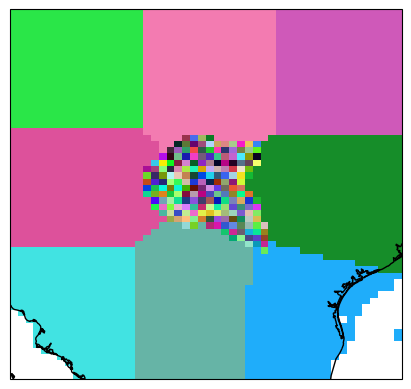

In [13]:
# cluster the buffer elements with the above function
state_vector = cluster_buffer_elements(state_vector, config['nBufferClusters'], state_vector.max().item())

# Add units attribute
state_vector.attrs['units'] = 'none'
state_vector
            
# Plot
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
num_colors = state_vector.where(mask).max().item()
sv_cmap = matplotlib.colors.ListedColormap(np.random.rand(int(num_colors), 3))
state_vector.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=sv_cmap,
    add_colorbar=False,
)
ax.coastlines();

In [14]:
# Now set pixels over water (without offshore emissions) to missing_value = -9999
if config['LandThreshold']:
    state_vector.values[state_vector.isnull()] = -9999

## Save the state vector to netcdf

In [15]:
# Create dataset
ds_state_vector = xr.Dataset(
                {
                    "StateVector": (["lat", "lon"], state_vector.values),
                },
                coords={
                    "lon": ("lon", new_lon_grid),
                    "lat": ("lat", new_lat_grid),
                },
                
                )

# Add attribute metadata
ds_state_vector.lat.attrs['units'] = 'degrees_north'
ds_state_vector.lat.attrs['long_name'] = 'Latitude'
ds_state_vector.lon.attrs['units'] = 'degrees_east'
ds_state_vector.lon.attrs['long_name'] = 'Longitude'
ds_state_vector.StateVector.attrs['units'] = 'none'
ds_state_vector.StateVector.attrs['missing_value'] = -9999
ds_state_vector.StateVector.attrs['_FillValue'] = -9999
ds_state_vector

<xarray.Dataset> Size: 24kB
Dimensions:      (lat: 59, lon: 50)
Coordinates:
  * lon          (lon) float64 400B -110.3 -110.0 -109.7 ... -95.62 -95.31 -95.0
  * lat          (lat) float64 472B 24.5 24.75 25.0 25.25 ... 38.5 38.75 39.0
Data variables:
    StateVector  (lat, lon) float64 24kB -9.999e+03 -9.999e+03 ... 207.0 207.0

In [16]:
# Count elements
num_elements = int(state_vector.max().values)
print('State vector has',num_elements,'emission elements')

State vector has 208 emission elements


In [17]:
# Save
save = True  # Switch to True if you wish to save the state vector file

if save:
    save_pth = config["StateVectorFile"]
    ds_state_vector.to_netcdf(
        save_pth,
        encoding={
            v: {"zlib": True, "complevel": 1} for v in ds_state_vector.data_vars
        },
    )

----